In [1]:
import pandas as pd
import numpy as np

from collections import defaultdict
from typing import List
from scipy import stats
from datetime import datetime, timedelta

C:\Users\Vladislav\AppData\Local\Temp\ipykernel_8136\2199524301.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df_web_logs = pd.read_csv('../data/2022-04-01T12_df_web_logs.csv')
df_web_logs.head()

,user_id,page,date,load_time
0,f25239,m,2022-02-03 23:45:37,80.8
1,06d6df,m,2022-02-03 23:49:56,70.5
2,06d6df,m,2022-02-03 23:51:16,89.7
3,f25239,m,2022-02-03 23:51:43,74.4
4,697870,m,2022-02-03 23:53:12,66.8


## Сколько выбросов удалять
  

С одной стороны, при удалении выбросов снижается дисперсия, что приводит к увеличению чувствительности теста. С другой стороны, при удалении выбросов уменьшается размер выборки, что приводит к уменьшению чувствительности.

Сравните мощности тестов с разной долей удаляемых данных. Используйте данные о времени работы бэкенда 2022-04-01T12_df_web_logs.csv в период с 2022-03-01 по 2022-03-08. Уровень значимости — 0.05. Размеры групп — 1000 человек (размер выборок будет больше, так как на одного человека приходится много значений). Проверяем гипотезу о равенстве средних с помощью теста Стьюдента. Ожидаемый эффект — увеличение времени обработки на 1%. Эффект в синтетических А/В-тестах добавляем умножением на константу.

В ответ введите номера вариантов, упорядоченные по уменьшению мощности. Например, «12345» означает, что вариант 1 обладает наибольшей мощностью, а вариант 5 — наименьшей.

1. Удалить 0.02% выбросов;

2. Удалить 0.2% выбросов;

3. Удалить 2% выбросов;

4. Удалить 10% выбросов;

5. Удалить 20% выбросов.

Удалить 2% выбросов означает, что нужно убрать по 1% минимальных и максимальных значений выборки. То есть оставить значения, которые лежат между np.quantile(values, 0.01) и np.quantile(values, 0.99). Квантили вычислять для каждой групп отдельно.

In [31]:
def estimate_error(data_logs: pd.DataFrame,
                   begin_date: str=None,
                   end_date: str=None,
                   effect: float=1,
                   percent_remove: tuple=(0.02, 0.2,
                                        2.0, 10, 20)):

    data_period = data_logs[['user_id', 'date', 'load_time']].copy()

    if begin_date:
        data_period = data_period[data_period['date'] >= begin_date]
    if end_date:
        data_period = data_period[data_period['date'] < end_date]

    result_power = defaultdict(list)
    sample_size = 1000
    epsilon = 1 + effect / 100
    for _ in range(10000):
        users_a, users_b = np.random.choice(data_period['user_id'], (2, sample_size), False)
        origin_a = data_period.loc[data_period['user_id'].isin(users_a), 'load_time'].values
        origin_b = data_period.loc[data_period['user_id'].isin(users_b), 'load_time'].values
        origin_b *= epsilon

        for r in percent_remove:
            q = r / 100 / 2
            begin_a = np.quantile(origin_a, q)
            end_a = np.quantile(origin_a, 1 - q)
            group_a = origin_a[(origin_a > begin_a) & (origin_a < end_a)]

            begin_b = np.quantile(origin_b, q)
            end_b = np.quantile(origin_b, 1 - q)
            group_b = origin_b[(origin_b > begin_b) & (origin_b < end_b)]

            pvalue = stats.ttest_ind(group_a, group_b).pvalue
            result_power[r].append(pvalue < 0.05)

    for k, v in result_power.items():
        print(f'Outlier delete {k}%: {np.mean(v)}')

In [32]:
estimate_error(df_web_logs,
               begin_date='2022-03-01',
               end_date='2022-03-08')

Outlier delete 0.02%: 0.0801
Outlier delete 0.2%: 0.3421
Outlier delete 2.0%: 0.9616
Outlier delete 10%: 0.9769
Outlier delete 20%: 0.9829


## Сколько выбросов удалять — 2
  

Выполните то же задание, изменив способ добавления эффекта. Эффект в синтетических А/В-тестах добавляем добавлением константы к 1% данных.

В ответ введите номера вариантов упорядоченные по уменьшению мощности. Например, «12345» означает, что вариант 1 обладает наибольшей мощностью, а вариант 5 — наименьшей.

1. Удалить 0.02% выбросов;

2. Удалить 0.2% выбросов;

3. Удалить 2% выбросов;

4. Удалить 10% выбросов;

5. Удалить 20% выбросов.

Удалить 2% выбросов означает, что нужно убрать по 1% минимальных и максимальных значений выборки. То есть оставить значения, которые лежат между np.quantile(values, 0.01) и np.quantile(values, 0.99). Квантили вычислять для каждой группы отдельно.

In [38]:
def estimate_error2(data_logs: pd.DataFrame,
                   begin_date: str=None,
                   end_date: str=None,
                   effect: float=1,
                   percent_remove: tuple=(0.02, 0.2,
                                        2.0, 10, 20)):

    data_period = data_logs[['user_id', 'date', 'load_time']].copy()

    if begin_date:
        data_period = data_period[data_period['date'] >= begin_date]
    if end_date:
        data_period = data_period[data_period['date'] < end_date]

    result_power = defaultdict(list)
    sample_size = 1000
    for _ in range(10000):
        users_a, users_b = np.random.choice(data_period['user_id'], (2, sample_size), False)
        origin_a = data_period.loc[data_period['user_id'].isin(users_a), 'load_time'].values
        origin_b = data_period.loc[data_period['user_id'].isin(users_b), 'load_time'].values
        indexs = np.random.choice(np.arange(len(origin_b)), len(origin_b) // 100, False)
        origin_b[indexs] += origin_b.mean() * (effect / 100) * len(origin_b) / len(indexs)

        for r in percent_remove:
            q = r / 100 / 2
            begin_a = np.quantile(origin_a, q)
            end_a = np.quantile(origin_a, 1 - q)
            group_a = origin_a[(origin_a > begin_a) & (origin_a < end_a)]

            begin_b = np.quantile(origin_b, q)
            end_b = np.quantile(origin_b, 1 - q)
            group_b = origin_b[(origin_b > begin_b) & (origin_b < end_b)]

            pvalue = stats.ttest_ind(group_a, group_b).pvalue
            result_power[r].append(pvalue < 0.05)

    for k, v in result_power.items():
        print(f'Outlier delete {k}%: {np.mean(v)}')

In [39]:
estimate_error2(df_web_logs,
               begin_date='2022-03-01',
               end_date='2022-03-08')

Outlier delete 0.02%: 0.0877
Outlier delete 0.2%: 0.3372
Outlier delete 2.0%: 0.5146
Outlier delete 10%: 0.3218
Outlier delete 20%: 0.3427


## Разбиение на страты
  
Предположим, у нас есть набор признаков, которые вычисляются независимо от эксперимента. Используя эти признаки, нужно разбить объекты на страты так, чтобы дисперсия стратифицированного среднего была минимальна и доля каждой страты была не менее 5% от всех данных.

Данные разбиты на 2 части. Первая часть доступна для исследования по ссылке stratification_task_data_public.csv. Решение будет проверяться на второй части данных. Значения в столбцах
x1, ..., x10 — признаки, которые можно использовать для вычисления страт. Значения в столбце y — измерения, по которым будет вычисляться целевая метрика эксперимента.

In [3]:
df_strats = pd.read_csv('../data/stratification_task_data_public.csv')
df_strats.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
0,0.869,30,33.8,0,1,0.2,1992,1,1,1,1903
1,0.759,27,21.7,2,0,3.5,1995,1,1,2,1313
2,0.456,29,37.6,2,0,3.1,1993,0,0,0,1484
3,0.060,35,27.5,2,0,4.7,1988,0,0,1,1188
4,0.939,19,30.7,0,0,3.6,2003,1,1,2,842


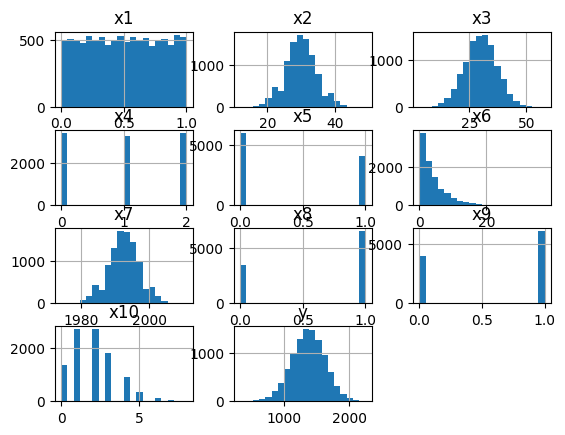

In [5]:
df_strats.hist(bins=20);

In [31]:
def get_strats(df: pd.DataFrame):
    """Возвращает страты объектов.
    
    :return (list | np.array | pd.Series): список страт объектов размера len(df).
    """
    temp = []
    for i in range(len(df)):
        row = df.iloc[i]
        temp.append(
            str(int(26 <= row['x2'] <= 34)) +
            str(int(row['x5'] == row['x9'])) +
            str(int(row['x10'] > 1))
        )

    return temp


def calculate_strat_var(df):
    """Вычисляет стратифицированную дисперсию популяции."""
    strat_vars = df.groupby('strat')['y'].var()
    weights = df['strat'].value_counts(normalize=True)
    stratified_var = (strat_vars * weights).sum()
    return stratified_var


if __name__ == "__main__":
    bound = 50000
    df = pd.read_csv('../data/stratification_task_data_public.csv')
    strats = get_strats(df.drop('y', axis=1))
    assert len(strats) == len(df), "Неверный размер списка страт"
    min_part = pd.Series(strats).value_counts(normalize=True).min()
    assert min_part >= 0.05, "Минимальная доля одной из страт меньше 5%"
    df['strat'] = strats
    strat_var = calculate_strat_var(df)
    err_msg = f"Дисперсия равна {strat_var:0.1f}, её нужно снизить до {bound}"
    assert strat_var <= bound, err_msg
    print(f'Отлично! Дисперсия равна {strat_var:0.1f}, меньше порога {bound}')

Отлично! Дисперсия равна 48882.0, меньше порога 50000


### ML решение (сложно интерпретировать)

```python
from lightgbm import LGBMRegressor

df_train = df_public.iloc[:len(df_public) // 2].copy()
df_test = df_public.iloc[len(df_public) // 2:].copy()

model = LGBMRegressor(num_leaves=3)
feature_names = [f'x{i}' for i in range(1, 11)]
model.fit(df_train[feature_names].values, df_train['y'].values)
predict_test = model.predict(df_test[feature_names].values)

n_strat = 10
quantiles = np.quantile(predict_test, np.linspace(0, 1 - 1 / n_strat, n_strat))
df_test['strat'] = [np.sum(predict >= quantiles) for predict in predict_test]
print(int(calculate_strat_var(df_test)))
```

## Оценка эксперимента с CUPED
  
Оцените эксперимент «Sending email (correct link)» с использованием CUPED. В качестве ковариаты используйте выручку пользователей за 4 недели до эксперимента.

In [2]:
df_sales = pd.read_csv('../data/2022-05-03T12_df_sales.csv')
df_pilot = pd.read_csv('../data/2022-05-03_experiment_users.csv')

In [128]:
def get_cuped_experiment(sales_data: pd.DataFrame,
                         pilot_data: pd.DataFrame,
                         begin_date: str,
                         end_date: str):
    
    df_sales = sales_data[['user_id', 'date', 'price']].copy()
    df_sales['date'] = pd.to_datetime(df_sales['date'])

    begin_date = datetime.strptime(begin_date, '%Y-%m-%d')
    end_date = datetime.strptime(end_date, '%Y-%m-%d')
    begin_cov_date = begin_date - timedelta(days=28)

    a_users = pilot_data[pilot_data['pilot'] == 0]
    b_users = pilot_data[pilot_data['pilot'] == 1]

    cov_metric = df_sales[(df_sales['date'] >= begin_cov_date) & \
                          (df_sales['date'] < begin_date)] \
                            .groupby('user_id')[['price']].sum().reset_index()
    metric = df_sales[(df_sales['date'] >= begin_date) & \
                      (df_sales['date'] < end_date)] \
                        .groupby('user_id')[['price']].sum().reset_index()

    X_a_group = a_users.merge(right=cov_metric,
                              how='left',
                              on='user_id')['price'].fillna(0)
    Y_a_group = a_users.merge(right=metric,
                              how='left',
                              on='user_id')['price'].fillna(0)
    
    X_b_group = b_users.merge(right=cov_metric,
                              how='left',
                              on='user_id')['price'].fillna(0)
    Y_b_group = b_users.merge(right=metric,
                              how='left',
                              on='user_id')['price'].fillna(0)

    y_metric = np.hstack((Y_a_group, Y_b_group))
    x_metric = np.hstack((X_a_group, X_b_group))
    theta = np.cov(x_metric, y_metric)[0][1] / x_metric.var()
    a_cuped = Y_a_group - theta * X_a_group    
    b_cuped = Y_b_group - theta * X_b_group

    pvalue = stats.ttest_ind(a_cuped, b_cuped).pvalue
    return pvalue

In [136]:
get_cuped_experiment(df_sales, df_pilot,
                     begin_date='2022-04-25',
                     end_date='2022-05-02')

0.05394611971573105

## Оценка эксперимента с линеаризацией
  
Раньше мы оценивали эксперимент "Refactoring backend", предполагая, что данные времени работы бэкенда независимые. Теперь мы можем корректно оценить этот эксперимент, даже если данные зависели бы от пользователей.

Оцените эксперимент "Refactoring backend" с использованием линеаризации в предположении, что данные пользователей зависимы.

In [2]:
df_logs = pd.read_csv('../data/2022-04-13T12_df_web_logs.csv')
df_exp = pd.read_csv('../data/2022-04-13_experiment_users.csv')

In [36]:
def linearization_experiment(df_logs: pd.DataFrame,
                             df_exp: pd.DataFrame,
                             begin_date: str,
                             end_date: str):
    a_users = df_exp[df_exp['pilot'] == 0][['user_id']]
    b_users = df_exp[df_exp['pilot'] == 1][['user_id']]

    data_logs = df_logs[(df_logs['date'] >= begin_date) & \
                        (df_logs['date'] < end_date)]
    data_logs = data_logs[['user_id', 'load_time']]

    a_group = a_users.merge(right=data_logs,
                            how='left',
                            on='user_id')
    b_group = b_users.merge(right=data_logs,
                            how='left',
                            on='user_id')

    k = a_group['load_time'].sum() / len(a_group)

    a_user_metric = a_group.groupby('user_id')[['load_time']].sum()
    a_user_count = a_group.groupby('user_id')[['load_time']].count()

    b_user_metric = b_group.groupby('user_id')[['load_time']].sum()
    b_user_count = b_group.groupby('user_id')[['load_time']].count()

    a_linear = a_user_metric['load_time'] - k * a_user_count['load_time']
    b_linear = b_user_metric['load_time'] - k * b_user_count['load_time']

    pvalue = stats.ttest_ind(a_linear.values, b_linear.values).pvalue
    return pvalue


In [41]:
linearization_experiment(df_logs,
                         df_exp,
                         begin_date='2022-04-05',
                         end_date='2022-04-12')

0.0441680027240742